For EDA please check [this](http://https://www.kaggle.com/muke5hy/eda-ieee-cis-fraud-detection) my another Kernel which only for the EDA. 

## Imports and Functions used in this kernel
They are in the hidden cell below.

In [1]:
import os
folder_path = '../input/ieee-fraud-detection/'
print(os.listdir(folder_path))

['train_identity.csv', 'test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv']


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import gc
from numba import jit
import seaborn as sns
from tqdm import tqdm_notebook
from itertools import product
from IPython.display import HTML
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.options.display.precision = 15
warnings.filterwarnings("ignore")
%matplotlib inline

        
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data loading and overview

Data is separated into two datasets: information about the identity of the customer and transaction information. Not all transactions belong to identities, which are available. Maybe it would be possible to use additional transactions to generate new features.

In [3]:
gc.collect()

8

# Modelling 
To start simple, I will start using as base the kernels below: <br>
https://www.kaggle.com/artkulak/ieee-fraud-simple-baseline-0-9383-lb - (@artkulak - Art) <br>
https://www.kaggle.com/artgor/eda-and-models - (@artgor - Andrew Lukyanenko)



In [4]:
%%time 
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')

train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')

sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv', index_col='TransactionID')

df_train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True, on='TransactionID')
df_test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True, on='TransactionID')

print(df_train.shape)
print(df_test.shape)

del train_transaction, train_identity, test_transaction, test_identity

(590540, 434)
(506691, 433)
CPU times: user 51.1 s, sys: 8.05 s, total: 59.2 s
Wall time: 59.4 s


#### Reduce the size for memory

In [5]:
%%time 
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)
CPU times: user 2min, sys: 5min 37s, total: 7min 38s
Wall time: 7min 38s


## Mapping emails

In [6]:
%%time 
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

CPU times: user 5.61 s, sys: 1.56 s, total: 7.17 s
Wall time: 7.18 s


### Encoding categorical features

In [7]:
%%time 

# Label Encoding
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))   

CPU times: user 1min 28s, sys: 368 ms, total: 1min 28s
Wall time: 1min 28s


In [8]:
%%time 
df_train = df_train.fillna(-999)
df_test = df_test.fillna(-999)

CPU times: user 3.03 s, sys: 348 ms, total: 3.38 s
Wall time: 3.39 s


## Baseline Model 

### RandomForest 

In [9]:
%%time 
y_train_full = df_train['isFraud'].copy()
X_train_full = df_train.drop('isFraud', axis=1)
X_test = df_test.copy()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


In [10]:
%%time 
X_train, X_val, y_train, Y_val = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.15, 
                                                    random_state=42)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


In [11]:
%%time 
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0, n_jobs=4)
clf.fit(X_train, y_train)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.4 µs


In [12]:
%%time 
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('RandomForest.csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs


### Delete BaseLine varaibles 

In [13]:
del X_train, X_val, y_train, Y_val
gc.collect()

# Feature engineering

In [14]:
%%time 
df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

CPU times: user 1.94 s, sys: 3.51 s, total: 5.45 s
Wall time: 5.48 s


# Training


## PCA 

### Concating dfs to get PCA of V features

In [15]:
%%time 
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)

CPU times: user 4.29 s, sys: 5.12 s, total: 9.41 s
Wall time: 9.43 s


In [16]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [17]:
mas_v = df_train.columns[55:394]

### Getting PCA 

In [18]:
%%time 

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)


CPU times: user 1min 22s, sys: 13.7 s, total: 1min 35s
Wall time: 1min 35s


In [19]:
%%time 

df = reduce_mem_usage(df)

Mem. usage decreased to 280.44 Mb (60.1% reduction)
CPU times: user 3.7 s, sys: 36 ms, total: 3.74 s
Wall time: 3.76 s



## Seting train and test back


In [20]:
%%time 
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

CPU times: user 900 ms, sys: 68 ms, total: 968 ms
Wall time: 972 ms


In [21]:
df_train.shape

(590540, 135)

## Seting X and y

In [22]:
%%time 

X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 
                                                      'TransactionDT', 
                                                      #'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT',
                                                    #'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train
df_test = df_test[["TransactionDT"]]

CPU times: user 844 ms, sys: 0 ns, total: 844 ms
Wall time: 847 ms


## XGBoost

### Defining the HyperOpt function with parameters space and model

In [23]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    gc.collect()
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}


In [24]:
gc.collect()

0

### Running the optimizer

In [25]:
%%time 

# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5)

# Print best parameters
best_params = space_eval(space, best)

                                                   
############## New Run ################
params = {'max_depth': 18, 'gamma': '0.111', 'subsample': '0.80', 'reg_alpha': '0.044', 'reg_lambda': '0.202', 'learning_rate': '0.102', 'num_leaves': '230.000', 'colsample_bytree': '0.609', 'min_child_samples': '210.000', 'feature_fraction': '0.644', 'bagging_fraction': '0.872'}
1 CV - score: 0.8952                               
2 CV - score: 0.8996                               
3 CV - score: 0.9197                               
4 CV - score: 0.8847                               
5 CV - score: 0.9234                               
6 CV - score: 0.9217                               
7 CV - score: 0.9158                               
Total Time Run: 4.25                               
Mean ROC_AUC: 0.9085661488426382                   
                                                                              
############## New Run ################
params = {'max_depth': 21, 'gamma': '0.2

### Best parameters

In [26]:
%%time 

print("BEST PARAMS: ", best_params)

best_params['max_depth'] = int(best_params['max_depth'])

BEST PARAMS:  {'bagging_fraction': 0.855607005067081, 'colsample_bytree': 0.6585423241060901, 'feature_fraction': 0.6705302185857918, 'gamma': 0.4335708568115242, 'learning_rate': 0.1069372351842376, 'max_depth': 21.0, 'min_child_samples': 140, 'num_leaves': 170, 'reg_alpha': 0.3912554824536911, 'reg_lambda': 0.06089791849210624, 'subsample': 0.7}
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 131 µs


### Predicting X test

In [27]:
%%time 

clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='gpu_hist'
)

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)[:,1] 

CPU times: user 43.4 s, sys: 23.4 s, total: 1min 6s
Wall time: 1min 6s


### Top 20 Feature importance

In [28]:
%%time 

feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 20 features
data.head(20)

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 1.98 s


,score
TransactionID,23735
card1,18200
TransactionAmt_to_mean_card1,16793
card2,15226
TransactionAmt_to_std_card1,14047
addr1,12901
TransactionAmt,9444
TransactionAmt_to_mean_card4,9350
TransactionAmt_to_std_card4,8958
card5,6199


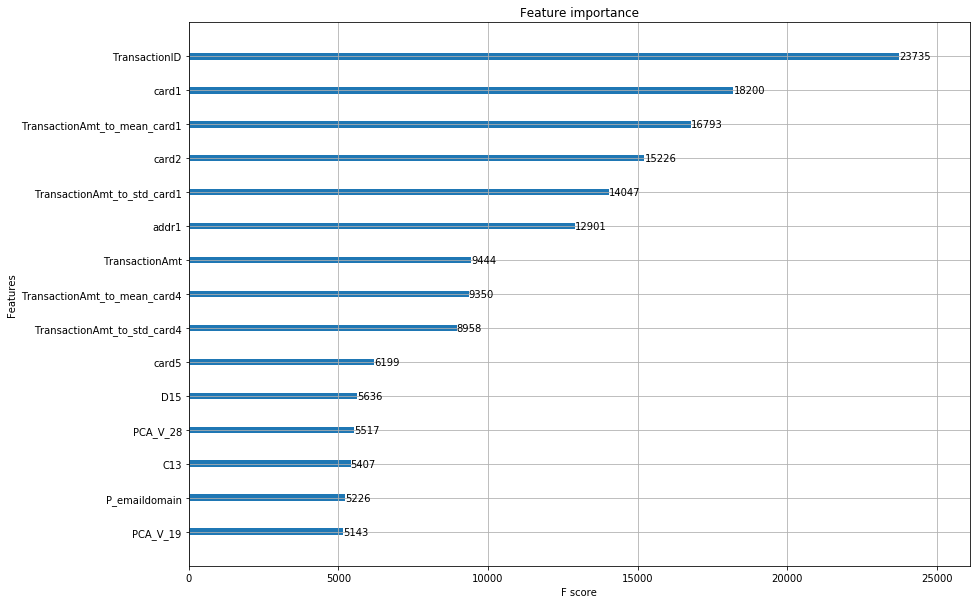

In [36]:

from xgboost import plot_importance
from matplotlib import pyplot

pyplot.rcParams["figure.figsize"] = (14, 10)
plot_importance(clf, max_num_features=15)
pyplot.show()

### Seting y_pred to csv

In [30]:

sample_submission['isFraud'] = y_preds
sample_submission.to_csv('XGB_hypopt_model.csv')

## LGBM

In [31]:
# predict with lightgbm, LeaveOneGroupOut 
# def pred_lgb_LOGO(X_train, Y_train, X_test, groups, params):
#     feature_importances = pd.DataFrame()
#     feature_importances['feature'] = X_train.columns

#     oof_preds = np.zeros(X_train.shape[0])
#     sub_preds = np.zeros(X_test.shape[0])

#     nfolds = groups.nunique()
#     print('groups:', nfolds)

#     kf = LeaveOneGroupOut()
#     pred_count = 0
#     for fold, (tt_index, out_index) in enumerate(kf.split(X_train, Y_train, groups)):
#         train_index = tt_index[tt_index < out_index[0]]
#         test_index = tt_index[tt_index > out_index[len(out_index) - 1]]
#         print(f'fold[{fold+1}] - {len(tt_index)} (train:{len(train_index)}, valid:{len(test_index)})')
#         if len(train_index) == 0 or len(test_index) == 0: # or len(train_index) < len(test_index)
#             print('- skip')
#             continue
        
#         pred_count += 1
        
#         dtrain = lgb.Dataset(X_train.iloc[train_index], label=Y_train.iloc[train_index])
#         dvalid = lgb.Dataset(X_train.iloc[test_index], label=Y_train.iloc[test_index])

#         clf = lgb.train(params, dtrain, 5000, 
#                         valid_sets=[dtrain, dvalid], valid_names=['train', 'valid'],
#                         verbose_eval=500, early_stopping_rounds=200)
#         feature_importances['fold_{}'.format(pred_count)] = clf.feature_importance()
#         oof_preds += clf.predict(X_train)
#         sub_preds += clf.predict(X_test) 

#     oof_preds = oof_preds / pred_count
#     sub_preds = sub_preds / pred_count 
        
#     return oof_preds, sub_preds, feature_importances

In [32]:
# %%time

# params={
#         #'boosting':'dart', # dart (drop out trees)
#         'learning_rate': 0.01,
#         'objective': 'binary',
#         'boost_from_average': False,
#         'is_unbalance': False,
#         'metric': 'auc',
#         'num_threads': -1,
#         'num_leaves': 128,
#         'max_bin': 256,
#         'verbose': 1,
#         'random_state': 42,
#         'bagging_fraction': 0.85,
#         'bagging_freq': 1,
#         'feature_fraction': 0.60
#     }

# oof_preds, sub_preds, feature_importances = pred_lgb_LOGO(X_train, Y_train, X_test, train_group, params)